# REST API for PACO server


The docs is available at http://localhost:8080/docs or at [docs](http://localhost:8080/docs) 

In [ ]:
#################
# IMPORTS
#################
import requests
import getpass
import re
import random
import string
#################
# HEADERS
#################
headers = {
    "Content-Type": "application/json",
}
url = "http://127.0.0.1:8000/"
chat_history = []

## Define the *BPMN+CPI*

In the following cell the *BPMN+CPI* is defined. 
 - expression: A string representing the BPMN expression, which defines the sequence and parallelism of tasks.
 - impacts: A dictionary where keys are task names and values are lists of impacts (e.g., costs, durations).
 - durations: A dictionary where keys are task names and values are lists representing the duration range [min, max] for each task.
 - probabilities: A dictionary where keys are natures (e.g., 'N1') and values are their probabilities.
 - loop_round: A dictionary for defining loop rounds, if any.
 - names: A dictionary mapping event names to their string representations that are displayed when the bpmn is drawn.
 - delays: A dictionary where keys are event names (e.g., 'C1') and values are their delays.
 - loop_probability: A dictionary for defining loop probabilities, if any.
 - impacts_names: A list of impact names (e.g., ['cost_electricity']).

In [5]:
bpmn = {
    'expression': 'Task0, (Task1 || Task4), (Task3 ^[N1] Task9, Task8 /[C1] Task2)', 
    'impacts': {'Task0': [0], 'Task1': [0], 'Task4': [0], 'Task3': [0], 'Task9': [0], 'Task8': [0], 'Task2': [0]}, 
    'durations': {'Task0': [0, 100], 'Task1': [0, 100], 'Task4': [0, 100], 'Task3': [0, 100], 'Task9': [0, 100], 'Task8': [0, 100], 'Task2': [0, 100]}, 
    'probabilities': {'N1': 0.5}, 
    'loop_round': {}, 
    'names': {'N1': 'N1', 'C1': 'C1'}, 
    'delays': {'C1': 0}, 
    'loop_probability': {}, 
    'impacts_names': ['cost_electricity']
}    

### GENERATE A RANDOM BPMN

In [ ]:
###########################
# Define the BPMN STRUCTURE
###########################
expression = "(((((((T1 , T2) ^[C1] ((T3 , T4) || T5)) , ((T6 , T7) / [N1] T8)) , ((T9 ^ [C2] T10) , (T11 , ((T12 , T13) , T14)))) , (((T15 ^ [C3] T16) / [N3] T17) / [N2] (T18 , T19))) ^ [C4] ((((T20 , T21) , T22) || T23) , ((T24 , T25) ^ [C5] T26))) || ((T27 || ((T28 / [N4] T29) ^ [N5] (T30 ^ [C6] (((T31 , T32) , ((T33 / [N7] T34) ^ [C7] T35)) , (T36 , T37))))) || T38))"

impacts_names = ["cost", "CO2"]

impacts_range = [1, 50]
duration_range = [1, 100]
delay_range = [0, 10]

tasks = sorted(set(re.findall(r'T\d+', expression)))
natures = sorted(set(re.findall(r'N\d+', expression)))
choices = sorted(set(re.findall(r'C\d+', expression)))
bpmn = {
    'expression': expression,
    'impacts': {task: [random.randint(impacts_range[0], impacts_range[1]) for _ in impacts_names] for task in tasks},
    'duration': {task: [1, random.randint(duration_range[0], duration_range[1])] for task in tasks},
    'impacts_names': impacts_names,
    'loop_probability': {},
    'delays': {choice: random.randint(delay_range[0], delay_range[1]) for choice in choices},
    'probabilities': {nature: round(random.uniform(0.1, 0.9), 2) for nature in natures},
    'names': {choice: choice for choice in choices} | {nature: nature for nature in natures},
    'loop_round': {}
}

### Check if the expression compliy with the defined grammmar

In [6]:
resp = requests.get(f'{url}check_correct_process_expression', params={'expression': bpmn['expression']},  headers=headers)
if resp.status_code != 200:
    print('Error in the request', resp.text)
elif resp.text == 'true':
    print('BPMN grammar is correct')
else:
    print('BPMN grammar is incorrect')

BPMN grammar is correct


### Print Diagram

In [ ]:
import pydot

data = {
    "bpmn": bpmn, 
}
response = requests.post(f'{url}create_sese_diagram', json=data,  headers=headers)
# Check if response is successful and save the file as a svg
if response.status_code == 200:
    print("Diagram created successfully")
    # transform the response into a pydot graph
    pydot_graph = pydot.graph_from_dot_data(response.json()['graph'])[0]
    # save the graph as a svg file
    pydot_graph.write_svg("diagram.svg")    
else:
    print(f"Error: {response.status_code}")
    print(f"Response: {response.text}")

Diagram created successfully


### Visualize diagram

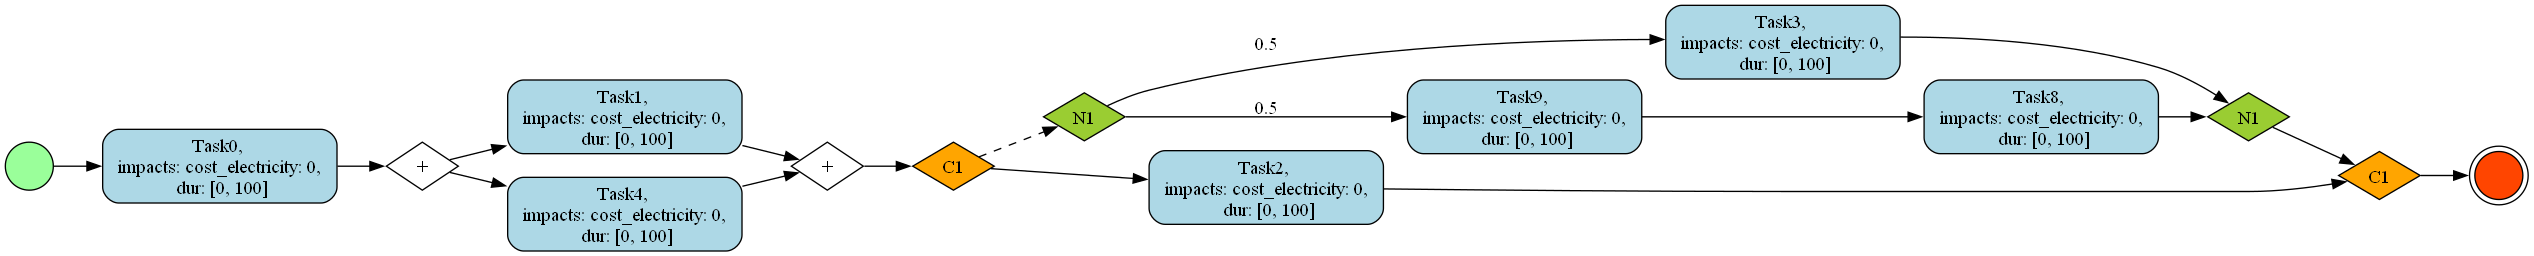

In [14]:
import io
from PIL import Image
from IPython.display import display
display(
    Image.open(
        io.BytesIO(
            pydot_graph.create_png()
            )
    )
)

## Calcolate strategy


Remember to choose an appropriate bound.

In [ ]:

data = {
    'bpmn': bpmn,          
    'bound': [20.0], 
    'algo': 'paco',
}
strat = requests.get(
    f'{url}calc_strategy_general',
    json=data,
    headers=headers,
)
if strat.status_code == 200:
    print(strat.text)
else:
    print(f"Error: {strat.status_code}")
    for key, value in strat.json().items():
        print(f"{key}: {value}")


## LLM


### Define the LLM

The definition is not a mandatory step, because when invoking the agent the llm  is initialized 

In [ ]:
data = {
    "url": input("Enter the URL of the model: "),
    "api_key": getpass.getpass("Enter the API key: "),
    "model": input("Enter the the model: "),
    "temperature": 0.7,
}
response = requests.get(f'{url}agent-definition', headers=headers, params=data)
if response.status_code == 200:
    print("Agent definition created successfully")
    llm = response.json()['llm']
else:
    print(f"Error: {response.status_code}")
    print(f"Response: {response.text}")

### Chat with the LMM 

In [ ]:
# If wanted can be used also this predefined prompt 
# prompt = '''
# Now I have to complete the writing task before 
# having a nature between talking with the publisher or to print the page written.
# Then, I choose between going to the park or continue writing.
# '''

prompt = input("Enter your prompt: ")
data = {
    "session_id": ''.join(random.choice(string.ascii_letters + string.digits) for i in range(8)), # Generates a random session id
    "prompt": prompt,
    "url": input("Enter the URL of the model: "),
    "api_key": getpass.getpass("Enter the API key: "),
    "model": input("Enter the the model: "),
    "temperature": 0.7,
    "verbose": False,
}
response = requests.post(f'{url}invoke-agent', headers=headers, json=data)

if response.status_code == 200:
    print(response.json()['response'])
    chat_history.append(response.json()['response'])
else:
    print(f"Error: {response.status_code}")
    print(f"Response: {response.text}")

In [ ]:
response.json()['history']